In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('bmh')

# custom figure styles
from plot_style import std_fig

# Newton methods

## Newton's method for root-finding

Newton's method (sometimes called the Newton-Raphson method) is a root-finding
algorithm which produces successively better approximations to the roots a
nonlinear equations.

The mental picture for Newton's method is to imagine the triangle formed by a
function evaluation and its derivative

<img src=img/newton1d.png width=400>

we have that we can write 

\begin{equation}
f^{\prime}(x_i) = \frac{\delta y}{\delta x} = \frac{f(x_i)}{\delta x} 
\Rightarrow \delta x = \frac{f(x_i)}{f^{\prime}(x_i)} 
\end{equation}

giving us an update rule of 

\begin{equation}
x_{i+1} = x_i - \frac{f(x_i)}{f^{\prime}(x_i)} 
\end{equation}

This method, especially in 1D, is easy to implement, and we provide a simple implementation below.

In [2]:
def newton_step(x0, f, df):
    """performs a step of newton's method in 1D"""
    return x0 - f(x0)/df(x0)

def newton1D(x0, f, df, tol=1e-12, max_iterations=100):
    """newton's method in 1D, finding f(x) = 0 for nonlinear f
    :param x0: starting guess
    :param f: function returning f(x)
    :param df: function which returns derivative df/dx(x)
    
    :returns: tuple (x_root, converged, x_history, error_history)
    """ 
    x_history, error_history = [x0], [f(x0)]
    
    x, converged, iterations = x0, False, 0
    while True:
        x = newton_step(x, f, df)
        error = f(x)
        iterations += 1
        
        x_history.append(x)
        error_history.append(error)
        
        if error < tol:
            converged = True
            break
        if iterations > max_iterations:
            break
            
    return (x, converged, x_history, error_history)

We show the performance of the algorithm for the simple 1D problem of finding the roots of the nonlinear polynomial $f(x) = x^2 - 2$.

In [3]:
x = np.linspace(-5, 10, 100)
y = x**2 - 2

In [4]:
f = lambda x: x**2 - 2
df = lambda x: 2*x

In [5]:
x_root, conv, x_hist, errs = newton1D(x0=10, f=f, df=df)

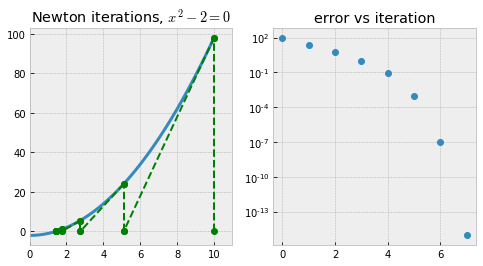

In [6]:
with std_fig(1, 2, figsize=(8, 4)) as (fig, ax):
    ax[0].plot(x, y, linewidth=3)
    for i in range(5):
        ax[0].plot([x_hist[i], x_hist[i+1]],
                [f(x_hist[i]), 0], 'o--', c='g')
        ax[0].plot([x_hist[i], x_hist[i]],
                [0, f(x_hist[i])], 'o--', c='g')
    ax[0].set_xlim([0, 11])
    ax[0].set_title(r'Newton iterations, $x^2-2=0$')
    ax[1].semilogy(np.arange(len(errs)), errs, 'o')
    ax[1].set_title('error vs iteration')

We can see the quadratic convergence in the error.

## Caveats for Newton's method

- convergence not guaranteed
    - estimate for root can grow unbounded
    - estimates can get caught in a cycles
- if first derivative is zero at root, the convergence is not quadratic

## Extension to multivariate Newton's method

Suppose we want to solve a system of nonlinear equations. This requires
generalization of the 1D case to a multivariate setting. 

### Preliminaries

Let ${g}: D\subseteq \mathbb{R}^n \to \mathbb{R}^m$ be a function which is
differentiable on $D$. We define the gradient $\nabla g\in \mathbb{R}^{m\times
n}$ of the function $g$ as:

\begin{equation}
\left[\nabla g\right]_{ij} \equiv \frac{\partial g_i}{\partial x_j}
\end{equation}

For a concrete example, take $f:\mathbb{R}^3 \to \mathbb{R}^2$

\begin{align}
f(x, y, z) =
\left[
\begin{array}{c}
x^2 + y^2 \\
x + z + 1 
\end{array}
\right],\,
\qquad
\nabla f =
\left[
\begin{array}{ccc}
2x & 2y & 0 \\
1 & 0 & 1\\
\end{array}
\right].
\end{align}

we see that $\nabla f \in \mathbb{R}^{2\times 3}$. That way, when we take the
product $\nabla f(x)(x-x_0)$ where $x,x_0\in \mathbb{R}^n$, we have a
well-defined matrix-vector product of an $m\times n$ matrix by an $n\times 1$
vector. Sometimes, for the case of $f:\mathbb{R}^n\to \mathbb{R}$, it will be
written $\nabla f(x_0)^T (x - x_0)$ for the tangent space, but it seems that the
transpose is only used to emphasize that this is a dot product. Unfortunately
there is no unified notation for the gradient and you always have to tread
carefully when writing things out in matrix-vector form.

### Generalization

Consider a system of nonlinear equations.  The mental picture for the Newton
method is the same, but the linear approximation to the function at a point
$x_i\in \mathbb{R}^n$ is now the tangent space to $g(x)$:

\begin{equation}
g_t(x) = g(x_i) + \nabla g(x_i)(x-x_i)
\end{equation}

For intuition, return to the 1D example for a moment. We drew things out
geometrically, but we could have expressed the tangent space as 

\begin{equation}
f_t(x) = f(x_i) + f^{\prime}(x_i)(x- x_i).
\end{equation}

We wanted to find the zero of this tangent space, namely, find
$x_{i+1}$ such that $f_t(x_{i+1}) = 0$, giving us 

\begin{equation}
f(x_i) + f^{\prime}(x_i)(x_{i+1} - x_i) = 0 \Rightarrow x_{i+1} = x_i -
\frac{f(x_i)}{f^{\prime}(x_{i})}.
\end{equation}

So the multivariate analogy is to find the point $x_{i+1}\in \mathbb{R}^n$ such
that $g_t(x_{i+1}) = 0$, yielding

\begin{align}
g(x_i) + \nabla g(x_i)(x_{i+1} - x_i) = 0  \\
\Rightarrow x_{i+1} = x_i - \left[\nabla g(x_i)\right]^{-1} g(x_i)
\end{align}

which reduces to the correct expression for the 1D case. In order to me
invertible, $\nabla g(x_i)$ must be a square matrix, so, practically, we can
restrict our attention to the case of $f:\mathbb{R}^n \to \mathbb{R}^n$.

### Practical considerations

In practice, it doesn't make sense to explicitly invert $\nabla g(x_i)$,
rather, call it the Jacobian matrix $J \equiv \nabla g(x)$ and we can think about the equivalent
problem where we define the increment vector 

\begin{equation}
\delta x \equiv x_{i+1}-x_i \qquad \in \mathbb{R}^n
\end{equation}

to compute the next iterate vector $x_{i+1}$ we solve the linear system 

\begin{equation}
J \delta x = - g(x_i)
\end{equation}

then update the solution as

\begin{equation}
x_{i+1} = x_i + \delta x
\end{equation}

However, this is a very naive algorithm and in practice, nonlinear root finding softwares almost never use such a simple method. See `scipy.optimize` suite of solvers, for example.

## Newton's method for optimization


An interesting perspective on the multivariate Newton's method is when used for
optimization. Suppose instead of a finding the root of a nonlinear set of
equations, we want to minimize or maximize a function $\ell(\theta)$ where
$\theta\in \mathbb{R}^n$. 

We've already done the heavy lifting, because we can view this as solving the
nonlinear system $\nabla \ell(\theta) = 0$. So we take $g(\theta) = \nabla
\ell(\theta)$, in which case the Jacobian matrix $J$ is the Hessian matrix $H$
of the function $\ell(\theta)$

\begin{equation}
  H(\ell(\theta)) = \nabla^2 \ell \qquad \text{where} \qquad 
  H_{ij} \equiv \frac{\partial^2 \ell(\theta) }{\partial \theta_i \partial \theta_j}
\end{equation}

Due to Fubini's theorem about the exchange of derivatives, $H = H^T$ is
symmetric. Then the update rule for Newton's method for optimization is 

\begin{equation}
\theta_{i+1} = \theta_i - H^{-1} \nabla_\theta \ell(\theta_i)
\end{equation}

### Interpretation for optimization

Newton's method for optimization admits a neat interpretation.

(Stuff about quadratic approximation near $\theta_i$.)
